# Flight Delay Validation
Trains and tests a suite of flight delay models along a moving time window to cross-validate model effectiveness. Estimates the proportion of delays that could be avoided using these model predictions.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
import matplotlib.pyplot as plt
from joblib import dump, load

In [2]:


print(tf.config.list_physical_devices('GPU'))
print('Number of GPUs Available: ', len(tf.config.list_physical_devices('GPU')))
print('Tensorflow version: '+tf.version.VERSION)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs Available:  1
Tensorflow version: 2.1.0


In [4]:
#set whether to train new models (True) or load old models (False)
train_new_model=True
save_metrics=True

#set delay prevention scheme
quantile_time_add=0.9#flights with delay probabilities >= this quantile should have time added to arrival
time_add=15#minutes to add to arrival times of flights with highest probability of delays

#output file names
output_folder='7-22_Jan2019-May2021_cross_val/'
metrics_output='metrics.csv'


#define the fist and last test month of the moving train-val-test windows
#Will test on these months, validate on month that is months_lag behind, 
#and train on each training_months period before validation.
test_list_start='2019_1'
test_list_end='2021_5'
months_lag=3 #number of months val month is behind test month
training_months=24


#define predictor variables
X_vars=['Month','DayOfWeek','Reporting_Airline',
            'Origin','Dest','OriginState','DestState',
            'CRSDepTime','CRSArrTime',
            'CRSElapsedTime'] #Distance highly correlated with elapsed time, use only one
X_vars_categorical=['Reporting_Airline','Origin','Dest','OriginState','DestState']
X_vars_hours=['CRSDepTime','CRSArrTime']
X_vars_cyclical_dict={'Month':12,'DayOfWeek':7,'CRSDepTime':24,'CRSArrTime':24}
X_vars_normalize=['CRSElapsedTime']
X_vars_log=['CRSElapsedTime'] #variables to log while normalizing, must be a subset of X_vars_normalize
y_var=['ArrDelayMinutes']

#define number of busiest airports to consider
num_airports=100

#define the delay length to consider
delay_minutes=15

#define the random fractions of train, validation, and test data to use
#true random subset if imbalanced==False, subset with increased % minority class (delays) if imbalanced==True
imbalanced=False
rand_frac_train=0.35
rand_frac_val=1
rand_frac_test=1

#define modeling parameters
Epochs = 15
Batch_Size = 2048



In [5]:
#function to import csv files into dataframe
def read_flight_csv(filenames,col_names):
    df=pd.read_csv(filenames[0],usecols=col_names)
    print('Read '+filenames[0])
    if len(filenames)>1:
        for i in np.arange(1,len(filenames)):
            df=df.append(pd.read_csv(filenames[i],usecols=col_names))
            print('Read '+filenames[i])
    df=df.reset_index(drop=True)
    return df

#make list of filenames to import in a range of months starting from given YYYY_MM strings
def make_filenames(start_date,end_date):
    filename_start='US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_'
    filename_ext='.csv'
    start=datetime.strptime(start_date,'%Y_%m')
    end=datetime.strptime(end_date,'%Y_%m')
    dates=pd.date_range(start,end,freq='MS')
    date_list=dates.strftime('%Y_%#m').tolist()
    files=[filename_start+date+filename_ext for date in date_list]
    return files


#create moving windows of train-val-test file names
#Tests 1 month, validates on previous 1 month, trains on the 24 months before val
#Input first and last test month
#Returns list of training file lists, list of val files, list of training files
from dateutil.relativedelta import relativedelta
def moving_train_val_test_windows(test_list_start,test_list_end,months_lag=1,training_months=24):
    
    test_list=make_filenames(test_list_start,test_list_end)
    test_list=[[file] for file in test_list]
    
    val_list_start=(datetime.strptime(test_list_start,'%Y_%m')-relativedelta(months=months_lag)).strftime('%Y_%#m')
    val_list_end=(datetime.strptime(test_list_end,'%Y_%m')-relativedelta(months=months_lag)).strftime('%Y_%#m')
    val_list=make_filenames(val_list_start,val_list_end)
    val_list=[[file] for file in val_list]

    train_list=['']*len(val_list)
    train_start_date=datetime.strptime(val_list_start,'%Y_%m')-relativedelta(months=training_months)
    train_end_date=datetime.strptime(val_list_start,'%Y_%m')-relativedelta(months=1)
    for i in np.arange(len(val_list)):
        train_list[i]=make_filenames(train_start_date.strftime('%Y_%#m'),train_end_date.strftime('%Y_%#m'))
        train_start_date=train_start_date+relativedelta(months=1)
        train_end_date=train_end_date+relativedelta(months=1)
    
    return train_list,val_list,test_list


In [6]:
#function to find the given number of busiest airports in a dataset
def airport_select(df,num_airports):
    arrivals=df.groupby(['Dest']).size()
    departures=df.groupby(['Origin']).size()
    flights=arrivals+departures
    airports=flights.sort_values(ascending=False)[:num_airports].index.tolist()
    return airports
    
#function to restrict to list of airports
#this helps limit training data size and in most cases gives consistent lists of airports for train, val, and test
def airport_restrict(df,airports):
    restricted=df[(df['Dest'].isin(airports))&(df['Origin'].isin(airports))]
    return restricted


#function to give airlines actual names
#translates select airlines that have been integrated into other airlines over time
def airline_names(df):
    carriers=pd.read_csv('US_DOT/On-Time/L_UNIQUE_CARRIERS.csv')
    carrier_dict=pd.Series(carriers['Description'].values,index=carriers['Code']).to_dict()
    df_new=df.copy()
    df_new['Reporting_Airline']=df['Reporting_Airline'].map(carrier_dict)
    df_new.loc[df_new['Reporting_Airline']=='Virgin America','Reporting_Airline']='Alaska Airlines Inc.'  #Virgin America integrated into Alaska Airlines in 2018
    return df_new



In [7]:

#function to encode cyclical time data into sin and cos variables
#usful resource at https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning
def convert_cyclical(df,col_name_maxval_dict):
    df_copy=df.copy()
    for col in col_name_maxval_dict.keys():
        max_value=col_name_maxval_dict[col]
        df_copy['sin('+col+')']=np.sin(2*np.pi*df_copy[col]/max_value)
        df_copy['cos('+col+')']=np.cos(2*np.pi*df_copy[col]/max_value)
        df_copy.drop(col,axis=1,inplace=True)
    return df_copy

#function to convert times to decimal hours. 
#Format in file is an integer with hour in thousands and hundreds place and minutes in tens and ones place 
#(For example, in input csv 1415 corresponds to 2:15pm, convert to decimal hour 14.25)
def convert_hours(df,columns):
    df_copy=df.copy()
    for col in columns:
        df_copy[col]=df[col]//100+(df[col]%100)/60
    return df_copy


#function to produce the desired predictor and target variable dataframes
def predictors_and_target(df,X_vars,X_vars_categorical,target_delay_minutes=1):
    subset=df[X_vars]
    X=pd.get_dummies(subset,columns=X_vars_categorical)#one-hot encode the categorical variables
    y=df['ArrDelayMinutes']>=target_delay_minutes
    return X,y


#function to choose random subset of matching predictor and target rows
#if subset_frac is not less than 1, returns copies of original X and y
def rand_subset(X,y,subset_frac,rand_state=0):
    if subset_frac<1:
        X_copy=X.copy()
        X_copy['y']=y
        samp=X_copy.sample(frac=subset_frac,random_state=rand_state)
        y_samp=samp['y']
        X_samp=samp.drop(['y'],axis=1)
    else:
        X_samp=X.copy()
        y_samp=y.copy()
    return X_samp,y_samp


#function to choose imbalanced random subset of matching predictor and target rows
#if subset_frac is not less than 1, returns copies of original X and y
#if sum(y==True)>=len(y)*subset_frac//2, will return rows with equal number of T and F values in y
#if sum(y==True)<len(y)*subset_frac//2, include all rows where y is T and len(y)*subset_frac//2 rows where y is F
#same conditions on sum(y==False)
def imbalanced_subsample(X,y,subset_frac,rand_state=0):
    if subset_frac<1:
        X_copy=X.copy()
        X_copy['y']=y
        X_copy_T=X_copy[X_copy['y']==True]
        X_copy_F=X_copy[X_copy['y']==False]
        num_samp=X_copy.shape[0]*subset_frac
        if X_copy_T.shape[0]>=num_samp//2:
            samp_T=X_copy_T.sample(n=int(num_samp//2),random_state=rand_state)
        else:
            samp_T=X_copy_T
        if X_copy_F.shape[0]>=num_samp//2:
            samp_F=X_copy_F.sample(n=int(num_samp//2),random_state=rand_state)
        else:
            samp_F=X_copy_F
        samp=samp_T.append(samp_F)
        y_samp=samp['y']
        X_samp=samp.drop(['y'],axis=1)
    else:
        X_samp=X.copy()
        y_samp=y.copy()
    return X_samp,y_samp


#function to normalize continuous varaibles in train and test data
def normalize(X_train,X_val,X_test,X_vars_normalize,X_vars_log):
    from sklearn.preprocessing import StandardScaler
    scaler=StandardScaler()
    
    train_to_scale=X_train.loc[:,X_vars_normalize]
    val_to_scale=X_val.loc[:,X_vars_normalize]
    test_to_scale=X_test.loc[:,X_vars_normalize]
    train_to_log=train_to_scale.loc[:,X_vars_log]
    val_to_log=val_to_scale.loc[:,X_vars_log]
    test_to_log=test_to_scale.loc[:,X_vars_log]
    
    X_train_out=X_train.copy()
    X_val_out=X_val.copy()
    X_test_out=X_test.copy()
    
    train_to_scale[X_vars_log]=np.log(train_to_log)
    train_scaled=scaler.fit_transform(train_to_scale)
    X_train_out[X_vars_normalize]=train_scaled
    
    val_to_scale[X_vars_log]=np.log(val_to_log)
    val_scaled=scaler.transform(val_to_scale)
    X_val_out[X_vars_normalize]=val_scaled
    
    test_to_scale[X_vars_log]=np.log(test_to_log)
    test_scaled=scaler.transform(test_to_scale)
    X_test_out[X_vars_normalize]=test_scaled
    
    return X_train_out,X_val_out,X_test_out,scaler

#function to add variables from train that are missing in validation or test
#additionally re-orders columns of val and train to match order in test
def missing_cat_add(X_train,X_val,X_test):
    X_val_new=X_val.reindex(columns=X_train.columns.values.tolist(),fill_value=0)
    
    X_test_new=X_test.reindex(columns=X_train.columns.values.tolist(),fill_value=0)
    
    return X_val_new,X_test_new


#function to normalize continuous varaibles for test data only (loaded previous trained model parameters)
def normalize_test_only(X,X_vars_normalize,X_vars_log,scaler):    
    X_to_scale=X.loc[:,X_vars_normalize]
    X_to_log=X_to_scale.loc[:,X_vars_log]
    X_out=X.copy()
    
    X_to_scale[X_vars_log]=np.log(X_to_log)
    X_scaled=scaler.transform(X_to_scale)
    X_out[X_vars_normalize]=X_scaled

    return X_out


#function to add categorical variables from train that are missing in test only (loaded previous trained model parameters)
def missing_cat_add_test_only(X_test,X_train_cols):
    X_test_new=X_test.reindex(columns=X_train_cols,fill_value=0)
    
    return X_test_new

In [8]:
#Read csv flight data, restrict airport list, convert hour and other cyclical data, and return predictor and target
#Must give either the number of airports (for train) or an airport list (for val and test)
def import_data(filenames,rand_frac,X_vars,X_vars_categorical,y_var,delay_minutes,
                X_vars_hours,X_vars_cyclical_dict,
                num_airports=None,airports_list=None,subsample_imbalanced=False):
    
    df=read_flight_csv(filenames,X_vars+y_var)
    df.dropna(inplace=True)  
    #EDA not shown here finds a few hundred CRSElapsedTime values missing some months, 
    #otherwise few tens of thousands of delay time targets missing out of half a million flights in a month
    if airports_list is not None:
        airports=airports_list
    else:
        airports=airport_select(df,num_airports)
    df_restricted=airline_names(airport_restrict(df,airports))
    
    X,y_full=predictors_and_target(df_restricted,X_vars,X_vars_categorical,delay_minutes)
    X_hours=convert_hours(X,X_vars_hours)
    X_full=convert_cyclical(X_hours,X_vars_cyclical_dict)
    
    if subsample_imbalanced:
        X_samp,y_samp=imbalanced_subsample(X_full,y_full,rand_frac)
    else:
        X_samp,y_samp=rand_subset(X_full,y_full,rand_frac)
    
    return X_samp,y_samp,airports,X_full,y_full,df_restricted


In [9]:
#create modeling procedure
#usful reference at https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

Metrics=[
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc')]

def make_model(metrics=Metrics):
    model = keras.Sequential([
        keras.layers.Dense(
            16, activation='relu',
            input_shape=(X_train_normalized.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid')])
    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)
    
    return model



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [10]:
#function to evaluate performance of a single model
def evaluate_model(y_test,y_pred,y_prob,plot=True):
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score
    accuracy=accuracy_score(y_test, y_pred)
    precision=precision_score(y_test, y_pred)
    recall=recall_score(y_test, y_pred)
    
    from sklearn.metrics import roc_curve, auc
    fpr,tpr,_=roc_curve(y_test,y_prob[:,-1])
    roc_auc=auc(fpr,tpr)
    
    from sklearn.metrics import confusion_matrix
    confusion=confusion_matrix(y_test,y_pred)
    
    print('')
    print('Test Accuracy: {:.3f}'.format(accuracy))
    print('Test Precision: {:.3f}'.format(precision))
    print('Test Recall: {:.3f}'.format(recall))
    print('Test ROC Area Under Curve: {:.3f}'.format(roc_auc))
    print('Test confusion:')
    print(confusion)
    print('')
    
    if plot:
    
        f,ax=plt.subplots(1,2,figsize=(11,5))
    
        ax[0].plot(fpr,tpr)
        ax[0].plot([0, 1], [0, 1], color='black', linestyle='--')
        ax[0].set_xlim([0,1])
        ax[0].set_ylim([0,1])
        ax[0].axes.set_aspect('equal')
        ax[0].set_xlabel('False Positive Rate')
        ax[0].set_ylabel('True Positive Rate')
        ax[0].set_title('ROC curve (area = {:.3f})'.format(roc_auc))

        from sklearn.metrics import precision_recall_curve
        precision_list, recall_list, thresholds = precision_recall_curve(y_test, y_prob[:,-1])
        ax[1].plot(precision_list, recall_list)
        ax[1].set_xlim([0,1])
        ax[1].set_ylim([0,1])
        ax[1].axes.set_aspect('equal')
        ax[1].set_xlabel('Precision')
        ax[1].set_ylabel('Recall')
    
        plt.show()
    
    return accuracy, precision, recall, roc_auc, confusion

******************************

Start model number 1

start data import 2021-07-22 22:54:14.516463
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2016_10.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2016_11.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2016_12.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_1.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_2.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_3.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_4.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_5.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_6.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(198

C:\Users\gtate\Anaconda3\envs\tensorflow_environment\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Test Accuracy: 0.816
Test Precision: 0.000
Test Recall: 0.000
Test ROC Area Under Curve: 0.634
Test confusion:
[[384853      0]
 [ 86956      0]]



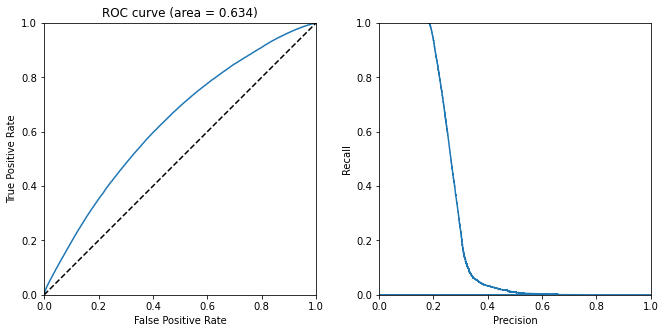

Model metrics with p=0.189:

Test Accuracy: 0.572
Test Precision: 0.246
Test Recall: 0.641
Test ROC Area Under Curve: 0.634
Test confusion:
[[213951 170902]
 [ 31251  55705]]

***

Stratified dummy classifier:

Test Accuracy: 0.695
Test Precision: 0.183
Test Recall: 0.189
Test ROC Area Under Curve: 0.501
Test confusion:
[[311721  73132]
 [ 70558  16398]]

******************************

******************************

******************************

Start model number 2

start data import 2021-07-22 23:12:49.227540
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2016_11.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2016_12.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_1.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_2.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_3.csv
Read US_DOT/On-Ti

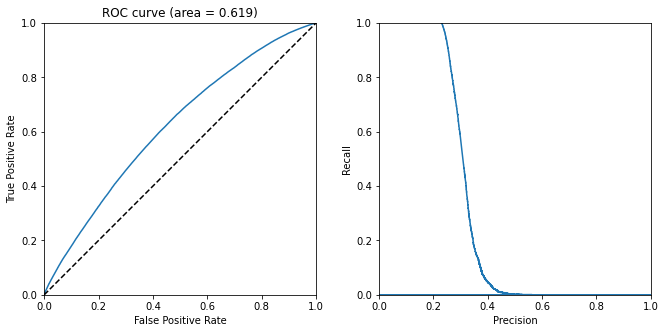

Model metrics with p=0.190:

Test Accuracy: 0.586
Test Precision: 0.298
Test Recall: 0.588
Test ROC Area Under Curve: 0.619
Test confusion:
[[193964 137306]
 [ 40854  58369]]

***

Stratified dummy classifier:

Test Accuracy: 0.668
Test Precision: 0.233
Test Recall: 0.192
Test ROC Area Under Curve: 0.500
Test confusion:
[[268575  62695]
 [ 80168  19055]]

******************************

******************************

******************************

Start model number 3

start data import 2021-07-22 23:30:32.029686
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2016_12.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_1.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_2.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_3.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_4.csv
Read US_DOT/On-Tim

Epoch 13/15
3726257/3726257 [==============================] - 64s 17us/sample - loss: 0.4655 - tp: 15916.0000 - fp: 16708.0000 - tn: 2993908.0000 - fn: 699725.0000 - accuracy: 0.8077 - precision: 0.4879 - recall: 0.0222 - auc: 0.6577 - val_loss: 0.4608 - val_tp: 79.0000 - val_fp: 40.0000 - val_tn: 399499.0000 - val_fn: 89832.0000 - val_accuracy: 0.8164 - val_precision: 0.6639 - val_recall: 8.7865e-04 - val_auc: 0.6312
Epoch 14/15
3726257/3726257 [==============================] - 64s 17us/sample - loss: 0.4655 - tp: 15887.0000 - fp: 16936.0000 - tn: 2993680.0000 - fn: 699754.0000 - accuracy: 0.8077 - precision: 0.4840 - recall: 0.0222 - auc: 0.6579 - val_loss: 0.4606 - val_tp: 92.0000 - val_fp: 53.0000 - val_tn: 399486.0000 - val_fn: 89819.0000 - val_accuracy: 0.8164 - val_precision: 0.6345 - val_recall: 0.0010 - val_auc: 0.6319
Epoch 15/15
3726257/3726257 [==============================] - 63s 17us/sample - loss: 0.4655 - tp: 15851.0000 - fp: 16758.0000 - tn: 2993858.0000 - fn: 69979

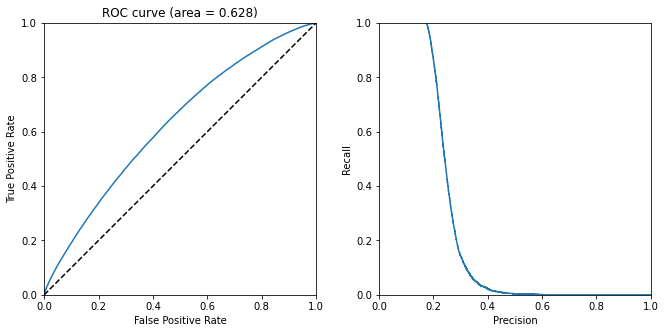

Model metrics with p=0.192:

Test Accuracy: 0.619
Test Precision: 0.237
Test Recall: 0.540
Test ROC Area Under Curve: 0.628
Test confusion:
[[269626 154642]
 [ 40942  48103]]

***

Stratified dummy classifier:

Test Accuracy: 0.701
Test Precision: 0.172
Test Recall: 0.190
Test ROC Area Under Curve: 0.500
Test confusion:
[[342753  81515]
 [ 72098  16947]]

******************************

******************************

******************************

Start model number 4

start data import 2021-07-22 23:48:58.322260
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_1.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_2.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_3.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_4.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_5.csv
Read US_DOT/On-Time

Epoch 13/15
3760323/3760323 [==============================] - 65s 17us/sample - loss: 0.4631 - tp: 15489.0000 - fp: 15896.0000 - tn: 3028127.0000 - fn: 700811.0000 - accuracy: 0.8094 - precision: 0.4935 - recall: 0.0216 - auc: 0.6586 - val_loss: 0.4606 - val_tp: 32.0000 - val_fp: 12.0000 - val_tn: 384841.0000 - val_fn: 86924.0000 - val_accuracy: 0.8157 - val_precision: 0.7273 - val_recall: 3.6800e-04 - val_auc: 0.6389
Epoch 14/15
3760323/3760323 [==============================] - 64s 17us/sample - loss: 0.4630 - tp: 15487.0000 - fp: 16148.0000 - tn: 3027875.0000 - fn: 700813.0000 - accuracy: 0.8093 - precision: 0.4896 - recall: 0.0216 - auc: 0.6589 - val_loss: 0.4608 - val_tp: 24.0000 - val_fp: 9.0000 - val_tn: 384844.0000 - val_fn: 86932.0000 - val_accuracy: 0.8157 - val_precision: 0.7273 - val_recall: 2.7600e-04 - val_auc: 0.6381
Epoch 15/15
3760323/3760323 [==============================] - 65s 17us/sample - loss: 0.4630 - tp: 15218.0000 - fp: 16039.0000 - tn: 3027984.0000 - fn: 70

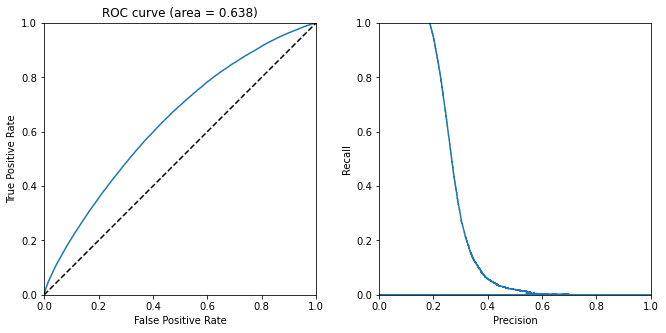

Model metrics with p=0.190:

Test Accuracy: 0.574
Test Precision: 0.249
Test Recall: 0.641
Test ROC Area Under Curve: 0.638
Test confusion:
[[226230 178791]
 [ 33117  59227]]

***

Stratified dummy classifier:

Test Accuracy: 0.694
Test Precision: 0.185
Test Recall: 0.189
Test ROC Area Under Curve: 0.500
Test confusion:
[[327777  77244]
 [ 74868  17476]]

******************************

******************************

******************************

Start model number 5

start data import 2021-07-23 00:07:33.462485
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_2.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_3.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_4.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_5.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_6.csv
Read US_DOT/On-Time

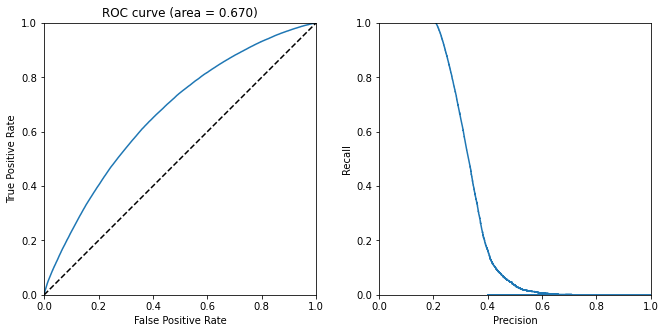

Model metrics with p=0.189:

Test Accuracy: 0.579
Test Precision: 0.290
Test Recall: 0.702
Test ROC Area Under Curve: 0.670
Test confusion:
[[223361 185283]
 [ 32134  75624]]

***

Stratified dummy classifier:

Test Accuracy: 0.681
Test Precision: 0.208
Test Recall: 0.189
Test ROC Area Under Curve: 0.502
Test confusion:
[[331209  77435]
 [ 87394  20364]]

******************************

******************************

******************************

Start model number 6

start data import 2021-07-23 00:26:14.633944
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_3.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_4.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_5.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_6.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_7.csv
Read US_DOT/On-Time

Epoch 13/15
3820856/3820856 [==============================] - 66s 17us/sample - loss: 0.4651 - tp: 16855.0000 - fp: 17783.0000 - tn: 3070963.0000 - fn: 715255.0000 - accuracy: 0.8081 - precision: 0.4866 - recall: 0.0230 - auc: 0.6569 - val_loss: 0.4468 - val_tp: 177.0000 - val_fp: 170.0000 - val_tn: 424098.0000 - val_fn: 88868.0000 - val_accuracy: 0.8265 - val_precision: 0.5101 - val_recall: 0.0020 - val_auc: 0.6283
Epoch 14/15
3820856/3820856 [==============================] - 67s 17us/sample - loss: 0.4651 - tp: 16836.0000 - fp: 17974.0000 - tn: 3070772.0000 - fn: 715274.0000 - accuracy: 0.8081 - precision: 0.4837 - recall: 0.0230 - auc: 0.6570 - val_loss: 0.4469 - val_tp: 283.0000 - val_fp: 265.0000 - val_tn: 424003.0000 - val_fn: 88762.0000 - val_accuracy: 0.8266 - val_precision: 0.5164 - val_recall: 0.0032 - val_auc: 0.6281
Epoch 15/15
3820856/3820856 [==============================] - 66s 17us/sample - loss: 0.4651 - tp: 17016.0000 - fp: 17796.0000 - tn: 3070950.0000 - fn: 71509

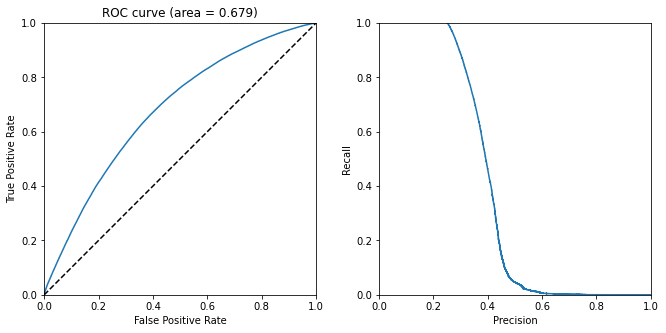

Model metrics with p=0.191:

Test Accuracy: 0.592
Test Precision: 0.349
Test Recall: 0.720
Test ROC Area Under Curve: 0.679
Test confusion:
[[209967 172423]
 [ 35830  92265]]

***

Stratified dummy classifier:

Test Accuracy: 0.654
Test Precision: 0.251
Test Recall: 0.191
Test ROC Area Under Curve: 0.499
Test confusion:
[[309403  72987]
 [103594  24501]]

******************************

******************************

******************************

Start model number 7

start data import 2021-07-23 00:45:40.534754
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_4.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_5.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_6.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_7.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_8.csv
Read US_DOT/On-Time

Epoch 13/15
3855881/3855881 [==============================] - 67s 17us/sample - loss: 0.4640 - tp: 14968.0000 - fp: 16299.0000 - tn: 3104617.0000 - fn: 719997.0000 - accuracy: 0.8090 - precision: 0.4787 - recall: 0.0204 - auc: 0.6565 - val_loss: 0.4613 - val_tp: 361.0000 - val_fp: 233.0000 - val_tn: 404788.0000 - val_fn: 91983.0000 - val_accuracy: 0.8146 - val_precision: 0.6077 - val_recall: 0.0039 - val_auc: 0.6407
Epoch 14/15
3855881/3855881 [==============================] - 67s 17us/sample - loss: 0.4640 - tp: 14766.0000 - fp: 15903.0000 - tn: 3105013.0000 - fn: 720199.0000 - accuracy: 0.8091 - precision: 0.4815 - recall: 0.0201 - auc: 0.6565 - val_loss: 0.4610 - val_tp: 262.0000 - val_fp: 165.0000 - val_tn: 404856.0000 - val_fn: 92082.0000 - val_accuracy: 0.8145 - val_precision: 0.6136 - val_recall: 0.0028 - val_auc: 0.6415
Epoch 15/15
3855881/3855881 [==============================] - 66s 17us/sample - loss: 0.4638 - tp: 15229.0000 - fp: 16075.0000 - tn: 3104841.0000 - fn: 71973

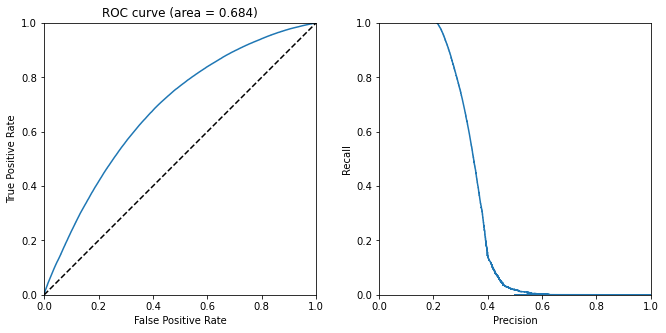

Model metrics with p=0.191:

Test Accuracy: 0.575
Test Precision: 0.300
Test Recall: 0.746
Test ROC Area Under Curve: 0.684
Test confusion:
[[218958 195479]
 [ 28599  83963]]

***

Stratified dummy classifier:

Test Accuracy: 0.678
Test Precision: 0.215
Test Recall: 0.192
Test ROC Area Under Curve: 0.500
Test confusion:
[[335461  78976]
 [ 90918  21644]]

******************************

******************************

******************************

Start model number 8

start data import 2021-07-23 01:04:57.908155
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_5.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_6.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_7.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_8.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_9.csv
Read US_DOT/On-Time

Epoch 13/15
3889222/3889222 [==============================] - 67s 17us/sample - loss: 0.4632 - tp: 13678.0000 - fp: 14222.0000 - tn: 3136304.0000 - fn: 725018.0000 - accuracy: 0.8099 - precision: 0.4903 - recall: 0.0185 - auc: 0.6557 - val_loss: 0.4823 - val_tp: 655.0000 - val_fp: 346.0000 - val_tn: 408296.0000 - val_fn: 107109.0000 - val_accuracy: 0.7919 - val_precision: 0.6543 - val_recall: 0.0061 - val_auc: 0.6749
Epoch 14/15
3889222/3889222 [==============================] - 67s 17us/sample - loss: 0.4632 - tp: 13700.0000 - fp: 14297.0000 - tn: 3136229.0000 - fn: 724996.0000 - accuracy: 0.8099 - precision: 0.4893 - recall: 0.0185 - auc: 0.6557 - val_loss: 0.4815 - val_tp: 796.0000 - val_fp: 466.0000 - val_tn: 408176.0000 - val_fn: 106968.0000 - val_accuracy: 0.7920 - val_precision: 0.6307 - val_recall: 0.0074 - val_auc: 0.6749
Epoch 15/15
3889222/3889222 [==============================] - 67s 17us/sample - loss: 0.4632 - tp: 13836.0000 - fp: 14291.0000 - tn: 3136235.0000 - fn: 724

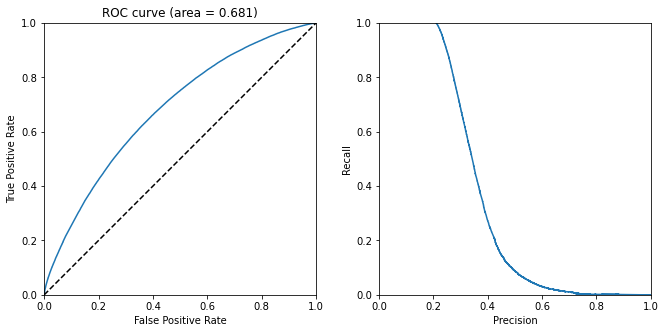

Model metrics with p=0.190:

Test Accuracy: 0.594
Test Precision: 0.299
Test Recall: 0.693
Test ROC Area Under Curve: 0.681
Test confusion:
[[237389 181245]
 [ 34123  77204]]

***

Stratified dummy classifier:

Test Accuracy: 0.679
Test Precision: 0.211
Test Recall: 0.192
Test ROC Area Under Curve: 0.500
Test confusion:
[[338617  80017]
 [ 89898  21429]]

******************************

******************************

******************************

Start model number 9

start data import 2021-07-23 01:24:27.815594
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_6.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_7.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_8.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_9.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_10.csv
Read US_DOT/On-Tim

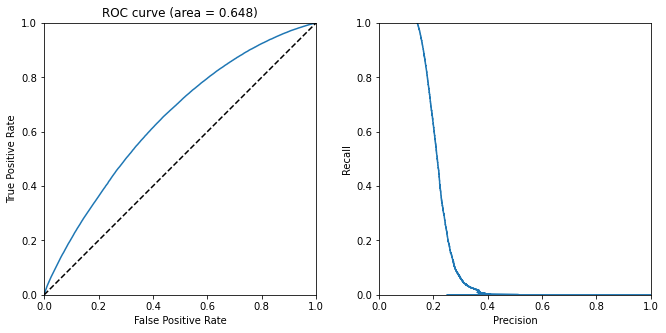

Model metrics with p=0.190:

Test Accuracy: 0.627
Test Precision: 0.206
Test Recall: 0.577
Test ROC Area Under Curve: 0.648
Test confusion:
[[268082 154125]
 [ 29204  39872]]

***

Stratified dummy classifier:

Test Accuracy: 0.723
Test Precision: 0.141
Test Recall: 0.189
Test ROC Area Under Curve: 0.501
Test confusion:
[[342238  79969]
 [ 56001  13075]]

******************************

******************************

******************************

Start model number 10

start data import 2021-07-23 01:44:09.261510
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_7.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_8.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_9.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_10.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_11.csv
Read US_DOT/On-T

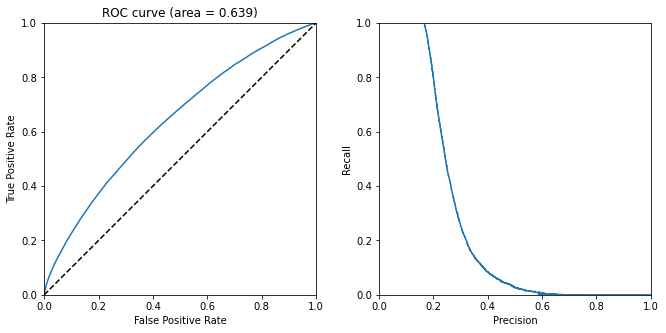

Model metrics with p=0.191:

Test Accuracy: 0.662
Test Precision: 0.245
Test Recall: 0.498
Test ROC Area Under Curve: 0.639
Test confusion:
[[302381 132915]
 [ 43466  43054]]

***

Stratified dummy classifier:

Test Accuracy: 0.707
Test Precision: 0.167
Test Recall: 0.192
Test ROC Area Under Curve: 0.500
Test confusion:
[[352246  83050]
 [ 69923  16597]]

******************************

******************************

******************************

Start model number 11

start data import 2021-07-23 02:03:54.355378
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_8.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_9.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_10.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_11.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_12.csv
Read US_DOT/On-

Epoch 13/15
3987707/3987707 [==============================] - 69s 17us/sample - loss: 0.4654 - tp: 12428.0000 - fp: 14181.0000 - tn: 3210839.0000 - fn: 750259.0000 - accuracy: 0.8083 - precision: 0.4671 - recall: 0.0163 - auc: 0.6554 - val_loss: 0.4801 - val_tp: 571.0000 - val_fp: 236.0000 - val_tn: 418398.0000 - val_fn: 110756.0000 - val_accuracy: 0.7906 - val_precision: 0.7076 - val_recall: 0.0051 - val_auc: 0.6823
Epoch 14/15
3987707/3987707 [==============================] - 70s 18us/sample - loss: 0.4654 - tp: 12396.0000 - fp: 14008.0000 - tn: 3211012.0000 - fn: 750291.0000 - accuracy: 0.8083 - precision: 0.4695 - recall: 0.0163 - auc: 0.6552 - val_loss: 0.4798 - val_tp: 730.0000 - val_fp: 310.0000 - val_tn: 418324.0000 - val_fn: 110597.0000 - val_accuracy: 0.7907 - val_precision: 0.7019 - val_recall: 0.0066 - val_auc: 0.6824
Epoch 15/15
3987707/3987707 [==============================] - 69s 17us/sample - loss: 0.4654 - tp: 12599.0000 - fp: 14163.0000 - tn: 3210857.0000 - fn: 750

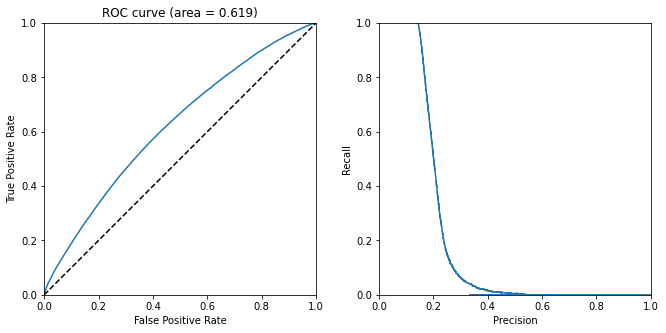

Model metrics with p=0.191:

Test Accuracy: 0.653
Test Precision: 0.203
Test Recall: 0.486
Test ROC Area Under Curve: 0.619
Test confusion:
[[288317 135445]
 [ 36432  34432]]

***

Stratified dummy classifier:

Test Accuracy: 0.720
Test Precision: 0.143
Test Recall: 0.191
Test ROC Area Under Curve: 0.500
Test confusion:
[[342520  81242]
 [ 57306  13558]]

******************************

******************************

******************************

Start model number 12

start data import 2021-07-23 02:24:19.546086
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_9.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_10.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_11.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_12.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_1.csv
Read US_DOT/On-

Epoch 13/15
4022548/4022548 [==============================] - 70s 17us/sample - loss: 0.4652 - tp: 12690.0000 - fp: 13777.0000 - tn: 3239100.0000 - fn: 756981.0000 - accuracy: 0.8084 - precision: 0.4795 - recall: 0.0165 - auc: 0.6556 - val_loss: 0.3929 - val_tp: 110.0000 - val_fp: 171.0000 - val_tn: 422036.0000 - val_fn: 68966.0000 - val_accuracy: 0.8593 - val_precision: 0.3915 - val_recall: 0.0016 - val_auc: 0.6527
Epoch 14/15
4022548/4022548 [==============================] - 71s 18us/sample - loss: 0.4653 - tp: 12507.0000 - fp: 13563.0000 - tn: 3239314.0000 - fn: 757164.0000 - accuracy: 0.8084 - precision: 0.4797 - recall: 0.0162 - auc: 0.6556 - val_loss: 0.3928 - val_tp: 135.0000 - val_fp: 188.0000 - val_tn: 422019.0000 - val_fn: 68941.0000 - val_accuracy: 0.8593 - val_precision: 0.4180 - val_recall: 0.0020 - val_auc: 0.6538
Epoch 15/15
4022548/4022548 [==============================] - 71s 18us/sample - loss: 0.4652 - tp: 13004.0000 - fp: 13866.0000 - tn: 3239011.0000 - fn: 75666

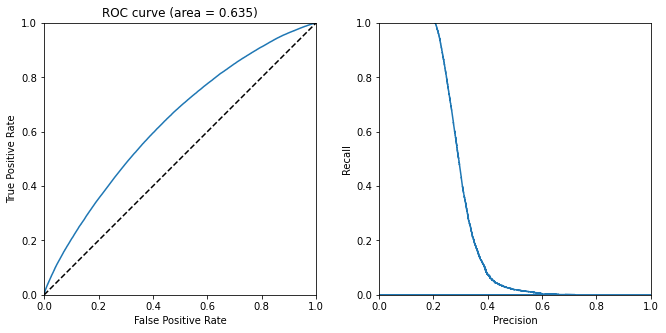

Model metrics with p=0.191:

Test Accuracy: 0.640
Test Precision: 0.291
Test Recall: 0.516
Test ROC Area Under Curve: 0.635
Test confusion:
[[272218 132546]
 [ 51064  54338]]

***

Stratified dummy classifier:

Test Accuracy: 0.681
Test Precision: 0.207
Test Recall: 0.192
Test ROC Area Under Curve: 0.500
Test confusion:
[[327091  77673]
 [ 85127  20275]]

******************************

******************************

******************************

Start model number 13

start data import 2021-07-23 02:44:50.232603
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_10.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_11.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_12.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_1.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_2.csv
Read US_DOT/On-

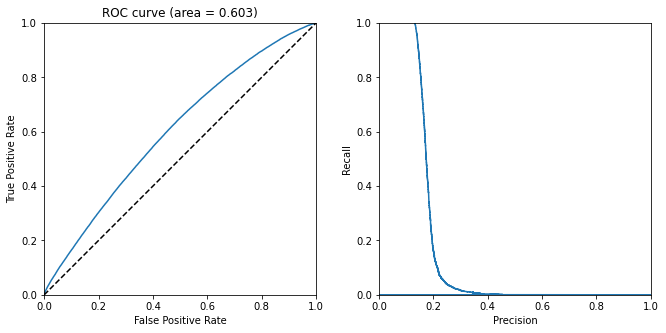

Model metrics with p=0.191:

Test Accuracy: 0.578
Test Precision: 0.170
Test Recall: 0.566
Test ROC Area Under Curve: 0.603
Test confusion:
[[248451 179766]
 [ 28218  36814]]

***

Stratified dummy classifier:

Test Accuracy: 0.727
Test Precision: 0.132
Test Recall: 0.191
Test ROC Area Under Curve: 0.499
Test confusion:
[[346355  81862]
 [ 52633  12399]]

******************************

******************************

******************************

Start model number 14

start data import 2021-07-23 03:05:21.843998
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_11.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_12.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_1.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_2.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_3.csv
Read US_DOT/On-T

Epoch 13/15
4089943/4089943 [==============================] - 72s 18us/sample - loss: 0.4653 - tp: 14619.0000 - fp: 15724.0000 - tn: 3292126.0000 - fn: 767474.0000 - accuracy: 0.8085 - precision: 0.4818 - recall: 0.0187 - auc: 0.6549 - val_loss: 0.4019 - val_tp: 48.0000 - val_fp: 44.0000 - val_tn: 423085.0000 - val_fn: 70709.0000 - val_accuracy: 0.8567 - val_precision: 0.5217 - val_recall: 6.7838e-04 - val_auc: 0.6190
Epoch 14/15
4089943/4089943 [==============================] - 71s 17us/sample - loss: 0.4652 - tp: 14838.0000 - fp: 15933.0000 - tn: 3291917.0000 - fn: 767255.0000 - accuracy: 0.8085 - precision: 0.4822 - recall: 0.0190 - auc: 0.6550 - val_loss: 0.4021 - val_tp: 36.0000 - val_fp: 31.0000 - val_tn: 423098.0000 - val_fn: 70721.0000 - val_accuracy: 0.8567 - val_precision: 0.5373 - val_recall: 5.0878e-04 - val_auc: 0.6200
Epoch 15/15
4089943/4089943 [==============================] - 71s 17us/sample - loss: 0.4653 - tp: 14651.0000 - fp: 15914.0000 - tn: 3291936.0000 - fn: 7

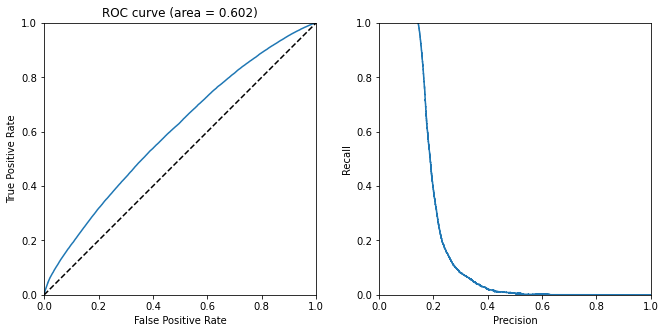

Model metrics with p=0.191:

Test Accuracy: 0.579
Test Precision: 0.182
Test Recall: 0.555
Test ROC Area Under Curve: 0.602
Test confusion:
[[232152 165894]
 [ 29670  37033]]

***

Stratified dummy classifier:

Test Accuracy: 0.720
Test Precision: 0.143
Test Recall: 0.191
Test ROC Area Under Curve: 0.499
Test confusion:
[[321813  76233]
 [ 53983  12720]]

******************************

******************************

******************************

Start model number 15

start data import 2021-07-23 03:26:07.004245
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_12.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_1.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_2.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_3.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_4.csv
Read US_DOT/On-Ti

Epoch 13/15
4124021/4124021 [==============================] - 73s 18us/sample - loss: 0.4665 - tp: 12622.0000 - fp: 13692.0000 - tn: 3319064.0000 - fn: 778643.0000 - accuracy: 0.8079 - precision: 0.4797 - recall: 0.0160 - auc: 0.6539 - val_loss: 0.4953 - val_tp: 30.0000 - val_fp: 13.0000 - val_tn: 404117.0000 - val_fn: 105327.0000 - val_accuracy: 0.7932 - val_precision: 0.6977 - val_recall: 2.8475e-04 - val_auc: 0.6318
Epoch 14/15
4124021/4124021 [==============================] - 73s 18us/sample - loss: 0.4664 - tp: 12763.0000 - fp: 13577.0000 - tn: 3319179.0000 - fn: 778502.0000 - accuracy: 0.8079 - precision: 0.4845 - recall: 0.0161 - auc: 0.6541 - val_loss: 0.4945 - val_tp: 68.0000 - val_fp: 34.0000 - val_tn: 404096.0000 - val_fn: 105289.0000 - val_accuracy: 0.7933 - val_precision: 0.6667 - val_recall: 6.4542e-04 - val_auc: 0.6329
Epoch 15/15
4124021/4124021 [==============================] - 73s 18us/sample - loss: 0.4664 - tp: 12749.0000 - fp: 13560.0000 - tn: 3319196.0000 - fn:

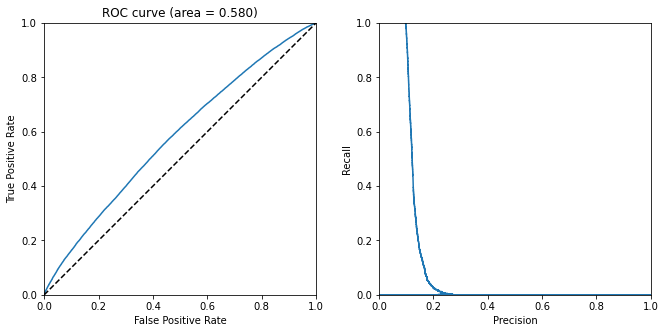

Model metrics with p=0.192:

Test Accuracy: 0.543
Test Precision: 0.119
Test Recall: 0.575
Test ROC Area Under Curve: 0.580
Test confusion:
[[212929 181461]
 [ 18157  24516]]

***

Stratified dummy classifier:

Test Accuracy: 0.748
Test Precision: 0.097
Test Recall: 0.190
Test ROC Area Under Curve: 0.500
Test confusion:
[[318625  75765]
 [ 34572   8101]]

******************************

******************************

******************************

Start model number 16

start data import 2021-07-23 03:47:01.127538
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_1.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_2.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_3.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_4.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_5.csv
Read US_DOT/On-Tim

Epoch 13/15
4161905/4161905 [==============================] - 73s 18us/sample - loss: 0.4682 - tp: 10233.0000 - fp: 10952.0000 - tn: 3347936.0000 - fn: 792784.0000 - accuracy: 0.8069 - precision: 0.4830 - recall: 0.0127 - auc: 0.6535 - val_loss: 0.3923 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 427511.0000 - val_fn: 64953.0000 - val_accuracy: 0.8681 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6000
Epoch 14/15
4161905/4161905 [==============================] - 73s 18us/sample - loss: 0.4682 - tp: 10085.0000 - fp: 10534.0000 - tn: 3348354.0000 - fn: 792932.0000 - accuracy: 0.8069 - precision: 0.4891 - recall: 0.0126 - auc: 0.6534 - val_loss: 0.3920 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 427511.0000 - val_fn: 64953.0000 - val_accuracy: 0.8681 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6033
Epoch 15/15
4161905/4161905 [==============================] - 74s 18us/sample - loss: 0.4681 - tp: 10328.0000 - fp: 10927.0000 - tn: 

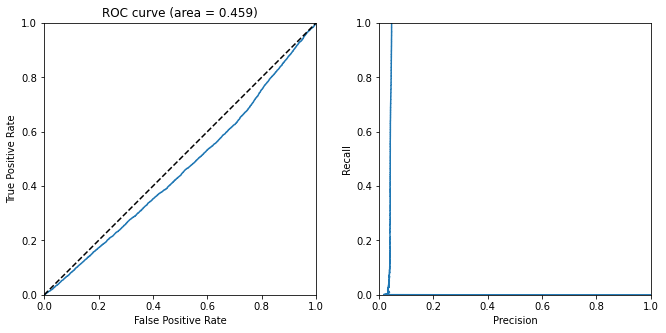

Model metrics with p=0.193:

Test Accuracy: 0.516
Test Precision: 0.041
Test Recall: 0.421
Test ROC Area Under Curve: 0.459
Test confusion:
[[71539 65855]
 [ 3880  2818]]

***

Stratified dummy classifier:

Test Accuracy: 0.780
Test Precision: 0.046
Test Recall: 0.189
Test ROC Area Under Curve: 0.505
Test confusion:
[[111091  26303]
 [  5430   1268]]

******************************

******************************

******************************

Start model number 17

start data import 2021-07-23 04:08:21.000080
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_2.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_3.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_4.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_5.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_6.csv
Read US_DOT/On-Time/On

Epoch 13/15
4173125/4173125 [==============================] - 73s 17us/sample - loss: 0.4657 - tp: 10005.0000 - fp: 10989.0000 - tn: 3364478.0000 - fn: 787653.0000 - accuracy: 0.8086 - precision: 0.4766 - recall: 0.0125 - auc: 0.6536 - val_loss: 0.4087 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 398046.0000 - val_fn: 66703.0000 - val_accuracy: 0.8565 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5971
Epoch 14/15
4173125/4173125 [==============================] - 72s 17us/sample - loss: 0.4656 - tp: 10172.0000 - fp: 11085.0000 - tn: 3364382.0000 - fn: 787486.0000 - accuracy: 0.8086 - precision: 0.4785 - recall: 0.0128 - auc: 0.6540 - val_loss: 0.4082 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 398046.0000 - val_fn: 66703.0000 - val_accuracy: 0.8565 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5978
Epoch 15/15
4173125/4173125 [==============================] - 73s 17us/sample - loss: 0.4657 - tp: 9764.0000 - fp: 10700.0000 - tn: 3

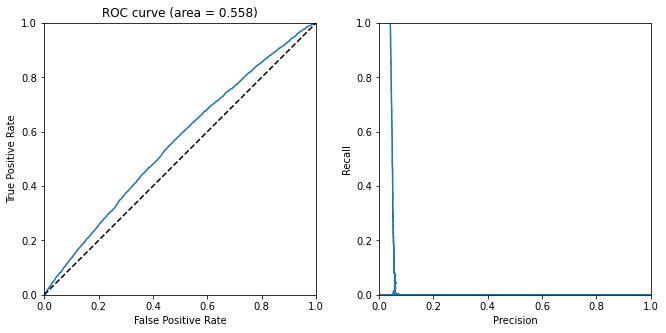

Model metrics with p=0.191:

Test Accuracy: 0.473
Test Precision: 0.048
Test Recall: 0.619
Test ROC Area Under Curve: 0.558
Test confusion:
[[58441 66638]
 [ 2046  3324]]

***

Stratified dummy classifier:

Test Accuracy: 0.783
Test Precision: 0.041
Test Recall: 0.193
Test ROC Area Under Curve: 0.494
Test confusion:
[[101125  23954]
 [  4335   1035]]

******************************

******************************

******************************

Start model number 18

start data import 2021-07-23 04:29:25.479470
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_3.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_4.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_5.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_6.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_7.csv
Read US_DOT/On-Time/On

Epoch 13/15
4187011/4187011 [==============================] - 75s 18us/sample - loss: 0.4631 - tp: 10362.0000 - fp: 11082.0000 - tn: 3383345.0000 - fn: 782222.0000 - accuracy: 0.8105 - precision: 0.4832 - recall: 0.0131 - auc: 0.6537 - val_loss: 0.3436 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 394390.0000 - val_fn: 42673.0000 - val_accuracy: 0.9024 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5831
Epoch 14/15
4187011/4187011 [==============================] - 73s 17us/sample - loss: 0.4630 - tp: 10469.0000 - fp: 11086.0000 - tn: 3383341.0000 - fn: 782115.0000 - accuracy: 0.8106 - precision: 0.4857 - recall: 0.0132 - auc: 0.6537 - val_loss: 0.3435 - val_tp: 0.0000e+00 - val_fp: 2.0000 - val_tn: 394388.0000 - val_fn: 42673.0000 - val_accuracy: 0.9024 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5846
Epoch 15/15
4187011/4187011 [==============================] - 74s 18us/sample - loss: 0.4630 - tp: 10752.0000 - fp: 11114.0000 - tn: 3383

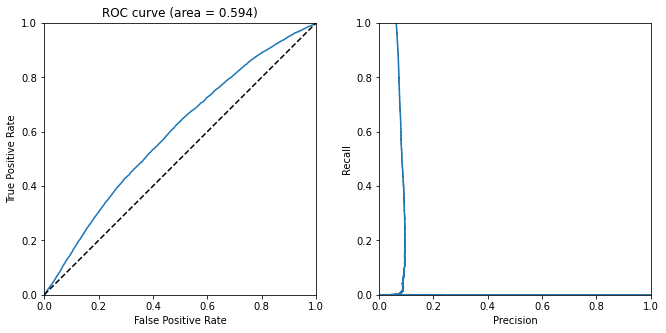

Model metrics with p=0.189:

Test Accuracy: 0.457
Test Precision: 0.077
Test Recall: 0.688
Test ROC Area Under Curve: 0.594
Test confusion:
[[73836 93532]
 [ 3535  7803]]

***

Stratified dummy classifier:

Test Accuracy: 0.771
Test Precision: 0.064
Test Recall: 0.191
Test ROC Area Under Curve: 0.503
Test confusion:
[[135672  31696]
 [  9167   2171]]

******************************

******************************

******************************

Start model number 19

start data import 2021-07-23 04:50:43.706912
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_4.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_5.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_6.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_7.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_8.csv
Read US_DOT/On-Time/On

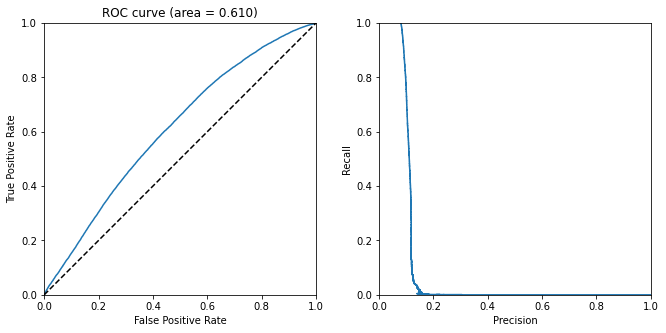

Model metrics with p=0.187:

Test Accuracy: 0.478
Test Precision: 0.102
Test Recall: 0.701
Test ROC Area Under Curve: 0.610
Test confusion:
[[117591 138759]
 [  6715  15761]]

***

Stratified dummy classifier:

Test Accuracy: 0.763
Test Precision: 0.080
Test Recall: 0.185
Test ROC Area Under Curve: 0.499
Test confusion:
[[208528  47822]
 [ 18324   4152]]

******************************

******************************

******************************

Start model number 20

start data import 2021-07-23 05:11:18.385807
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_5.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_6.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_7.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_8.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv
Read US_DOT/On-Tim

Epoch 13/15
4046307/4046307 [==============================] - 68s 17us/sample - loss: 0.4568 - tp: 13571.0000 - fp: 14754.0000 - tn: 3282129.0000 - fn: 735853.0000 - accuracy: 0.8145 - precision: 0.4791 - recall: 0.0181 - auc: 0.6551 - val_loss: 0.2742 - val_tp: 5.0000 - val_fp: 89.0000 - val_tn: 124990.0000 - val_fn: 5365.0000 - val_accuracy: 0.9582 - val_precision: 0.0532 - val_recall: 9.3110e-04 - val_auc: 0.5639
Epoch 14/15
4046307/4046307 [==============================] - 67s 17us/sample - loss: 0.4567 - tp: 13808.0000 - fp: 15047.0000 - tn: 3281836.0000 - fn: 735616.0000 - accuracy: 0.8145 - precision: 0.4785 - recall: 0.0184 - auc: 0.6555 - val_loss: 0.2720 - val_tp: 5.0000 - val_fp: 91.0000 - val_tn: 124988.0000 - val_fn: 5365.0000 - val_accuracy: 0.9582 - val_precision: 0.0521 - val_recall: 9.3110e-04 - val_auc: 0.5650
Epoch 15/15
4046307/4046307 [==============================] - 68s 17us/sample - loss: 0.4567 - tp: 13850.0000 - fp: 14841.0000 - tn: 3282042.0000 - fn: 73557

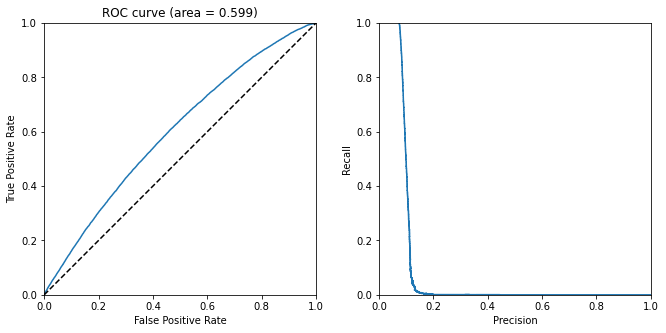

Model metrics with p=0.185:

Test Accuracy: 0.534
Test Precision: 0.094
Test Recall: 0.615
Test ROC Area Under Curve: 0.599
Test confusion:
[[144087 129260]
 [  8413  13460]]

***

Stratified dummy classifier:

Test Accuracy: 0.766
Test Precision: 0.073
Test Recall: 0.184
Test ROC Area Under Curve: 0.501
Test confusion:
[[222226  51121]
 [ 17853   4020]]

******************************

******************************

******************************

Start model number 21

start data import 2021-07-23 05:30:43.308613
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_6.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_7.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_8.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_10.csv
Read US_DOT/On-Ti

Epoch 13/15
3914405/3914405 [==============================] - 65s 17us/sample - loss: 0.4550 - tp: 10627.0000 - fp: 11770.0000 - tn: 3184376.0000 - fn: 707632.0000 - accuracy: 0.8162 - precision: 0.4745 - recall: 0.0148 - auc: 0.6534 - val_loss: 0.3172 - val_tp: 23.0000 - val_fp: 290.0000 - val_tn: 167078.0000 - val_fn: 11315.0000 - val_accuracy: 0.9351 - val_precision: 0.0735 - val_recall: 0.0020 - val_auc: 0.5957
Epoch 14/15
3914405/3914405 [==============================] - 65s 17us/sample - loss: 0.4549 - tp: 10582.0000 - fp: 11719.0000 - tn: 3184427.0000 - fn: 707677.0000 - accuracy: 0.8162 - precision: 0.4745 - recall: 0.0147 - auc: 0.6534 - val_loss: 0.3207 - val_tp: 34.0000 - val_fp: 381.0000 - val_tn: 166987.0000 - val_fn: 11304.0000 - val_accuracy: 0.9346 - val_precision: 0.0819 - val_recall: 0.0030 - val_auc: 0.5959
Epoch 15/15
3914405/3914405 [==============================] - 66s 17us/sample - loss: 0.4550 - tp: 10864.0000 - fp: 12057.0000 - tn: 3184089.0000 - fn: 707395.

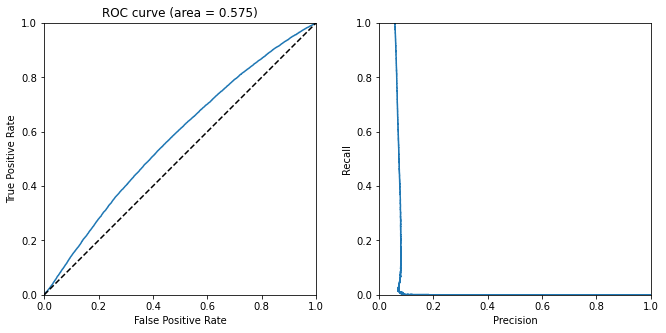

Model metrics with p=0.183:

Test Accuracy: 0.594
Test Precision: 0.073
Test Recall: 0.511
Test ROC Area Under Curve: 0.575
Test confusion:
[[142864  95607]
 [  7217   7548]]

***

Stratified dummy classifier:

Test Accuracy: 0.781
Test Precision: 0.058
Test Recall: 0.180
Test ROC Area Under Curve: 0.500
Test confusion:
[[194999  43472]
 [ 12104   2661]]

******************************

******************************

******************************

Start model number 22

start data import 2021-07-23 05:49:31.534895
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_7.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_8.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_10.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_11.csv
Read US_DOT/On-T

Epoch 13/15
3799118/3799118 [==============================] - 65s 17us/sample - loss: 0.4501 - tp: 9150.0000 - fp: 10143.0000 - tn: 3107322.0000 - fn: 672503.0000 - accuracy: 0.8203 - precision: 0.4743 - recall: 0.0134 - auc: 0.6498 - val_loss: 0.3355 - val_tp: 127.0000 - val_fp: 770.0000 - val_tn: 255580.0000 - val_fn: 22349.0000 - val_accuracy: 0.9171 - val_precision: 0.1416 - val_recall: 0.0057 - val_auc: 0.6120
Epoch 14/15
3799118/3799118 [==============================] - 64s 17us/sample - loss: 0.4501 - tp: 8986.0000 - fp: 9846.0000 - tn: 3107619.0000 - fn: 672667.0000 - accuracy: 0.8203 - precision: 0.4772 - recall: 0.0132 - auc: 0.6497 - val_loss: 0.3345 - val_tp: 136.0000 - val_fp: 833.0000 - val_tn: 255517.0000 - val_fn: 22340.0000 - val_accuracy: 0.9169 - val_precision: 0.1404 - val_recall: 0.0061 - val_auc: 0.6114
Epoch 15/15
3799118/3799118 [==============================] - 65s 17us/sample - loss: 0.4501 - tp: 9250.0000 - fp: 9968.0000 - tn: 3107497.0000 - fn: 672403.000

C:\Users\gtate\Anaconda3\envs\tensorflow_environment\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Test Accuracy: 0.921
Test Precision: 0.000
Test Recall: 0.000
Test ROC Area Under Curve: 0.569
Test confusion:
[[254936      0]
 [ 21754      0]]



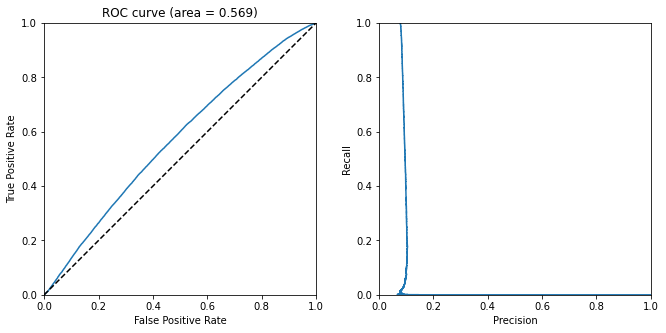

Model metrics with p=0.179:

Test Accuracy: 0.570
Test Precision: 0.095
Test Recall: 0.526
Test ROC Area Under Curve: 0.569
Test confusion:
[[146296 108640]
 [ 10308  11446]]

***

Stratified dummy classifier:

Test Accuracy: 0.771
Test Precision: 0.078
Test Recall: 0.178
Test ROC Area Under Curve: 0.501
Test confusion:
[[209415  45521]
 [ 17885   3869]]

******************************

******************************

******************************

Start model number 23

start data import 2021-07-23 06:08:15.688345
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_8.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_10.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_11.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_12.csv
Read US_DOT/On-

Epoch 13/15
3714359/3714359 [==============================] - 63s 17us/sample - loss: 0.4440 - tp: 6597.0000 - fp: 7482.0000 - tn: 3059075.0000 - fn: 641205.0000 - accuracy: 0.8254 - precision: 0.4686 - recall: 0.0102 - auc: 0.6455 - val_loss: 0.3073 - val_tp: 61.0000 - val_fp: 252.0000 - val_tn: 273095.0000 - val_fn: 21812.0000 - val_accuracy: 0.9253 - val_precision: 0.1949 - val_recall: 0.0028 - val_auc: 0.6031
Epoch 14/15
3714359/3714359 [==============================] - 63s 17us/sample - loss: 0.4439 - tp: 6484.0000 - fp: 7329.0000 - tn: 3059228.0000 - fn: 641318.0000 - accuracy: 0.8254 - precision: 0.4694 - recall: 0.0100 - auc: 0.6456 - val_loss: 0.3076 - val_tp: 58.0000 - val_fp: 235.0000 - val_tn: 273112.0000 - val_fn: 21815.0000 - val_accuracy: 0.9253 - val_precision: 0.1980 - val_recall: 0.0027 - val_auc: 0.6019
Epoch 15/15
3714359/3714359 [==============================] - 63s 17us/sample - loss: 0.4439 - tp: 6771.0000 - fp: 7702.0000 - tn: 3058855.0000 - fn: 641031.0000 -

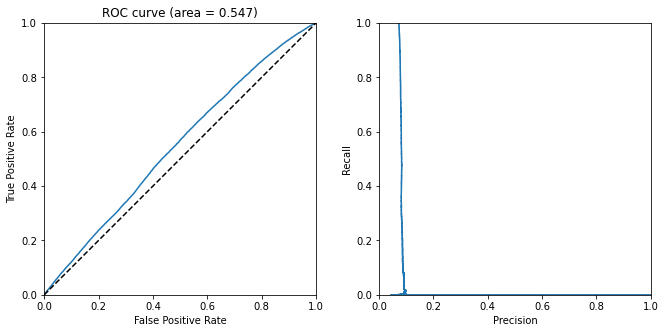

Model metrics with p=0.174:

Test Accuracy: 0.552
Test Precision: 0.083
Test Recall: 0.511
Test ROC Area Under Curve: 0.547
Test confusion:
[[148937 119164]
 [ 10311  10778]]

***

Stratified dummy classifier:

Test Accuracy: 0.779
Test Precision: 0.074
Test Recall: 0.175
Test ROC Area Under Curve: 0.499
Test confusion:
[[221489  46612]
 [ 17390   3699]]

******************************

******************************

******************************

Start model number 24

start data import 2021-07-23 06:26:27.483999
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_10.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_11.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_12.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2019_1.csv
Read US_DOT/On-

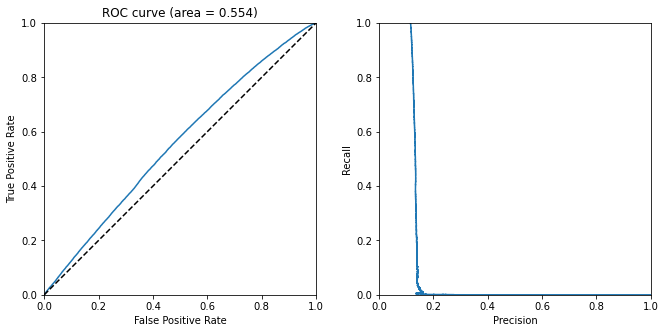

Model metrics with p=0.168:

Test Accuracy: 0.521
Test Precision: 0.132
Test Recall: 0.566
Test ROC Area Under Curve: 0.554
Test confusion:
[[132175 124670]
 [ 14558  19013]]

***

Stratified dummy classifier:

Test Accuracy: 0.755
Test Precision: 0.116
Test Recall: 0.169
Test ROC Area Under Curve: 0.500
Test confusion:
[[213557  43288]
 [ 27910   5661]]

******************************

******************************

******************************

Start model number 25

start data import 2021-07-23 06:43:54.168541
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_10.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_11.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_12.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2019_1.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2019_2.csv
Read US_DOT/On-

Epoch 13/15
3556810/3556810 [==============================] - 59s 17us/sample - loss: 0.4319 - tp: 4837.0000 - fp: 5669.0000 - tn: 2961786.0000 - fn: 584518.0000 - accuracy: 0.8341 - precision: 0.4604 - recall: 0.0082 - auc: 0.6415 - val_loss: 0.3005 - val_tp: 3.0000 - val_fp: 15.0000 - val_tn: 254921.0000 - val_fn: 21751.0000 - val_accuracy: 0.9213 - val_precision: 0.1667 - val_recall: 1.3791e-04 - val_auc: 0.5699
Epoch 14/15
3556810/3556810 [==============================] - 60s 17us/sample - loss: 0.4319 - tp: 4905.0000 - fp: 5732.0000 - tn: 2961723.0000 - fn: 584450.0000 - accuracy: 0.8341 - precision: 0.4611 - recall: 0.0083 - auc: 0.6420 - val_loss: 0.2999 - val_tp: 1.0000 - val_fp: 4.0000 - val_tn: 254932.0000 - val_fn: 21753.0000 - val_accuracy: 0.9214 - val_precision: 0.2000 - val_recall: 4.5969e-05 - val_auc: 0.5709
Epoch 15/15
3556810/3556810 [==============================] - 59s 17us/sample - loss: 0.4318 - tp: 4788.0000 - fp: 5713.0000 - tn: 2961742.0000 - fn: 584567.000

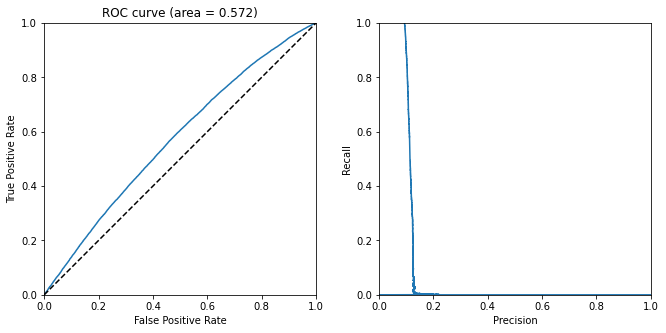

Model metrics with p=0.166:

Test Accuracy: 0.532
Test Precision: 0.112
Test Recall: 0.579
Test ROC Area Under Curve: 0.572
Test confusion:
[[133679 120139]
 [ 11071  15200]]

***

Stratified dummy classifier:

Test Accuracy: 0.771
Test Precision: 0.094
Test Recall: 0.166
Test ROC Area Under Curve: 0.498
Test confusion:
[[211618  42200]
 [ 21902   4369]]

******************************

******************************

******************************

Start model number 26

start data import 2021-07-23 07:01:05.228727
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_11.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_12.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2019_1.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2019_2.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2019_3.csv
Read US_DOT/On-T

Epoch 13/15
3475775/3475775 [==============================] - 59s 17us/sample - loss: 0.4281 - tp: 4131.0000 - fp: 4804.0000 - tn: 2903314.0000 - fn: 563526.0000 - accuracy: 0.8365 - precision: 0.4623 - recall: 0.0073 - auc: 0.6416 - val_loss: 0.2922 - val_tp: 0.0000e+00 - val_fp: 10.0000 - val_tn: 268091.0000 - val_fn: 21089.0000 - val_accuracy: 0.9270 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5511
Epoch 14/15
3475775/3475775 [==============================] - 59s 17us/sample - loss: 0.4281 - tp: 4093.0000 - fp: 4721.0000 - tn: 2903397.0000 - fn: 563564.0000 - accuracy: 0.8365 - precision: 0.4644 - recall: 0.0072 - auc: 0.6417 - val_loss: 0.2931 - val_tp: 1.0000 - val_fp: 17.0000 - val_tn: 268084.0000 - val_fn: 21088.0000 - val_accuracy: 0.9270 - val_precision: 0.0556 - val_recall: 4.7418e-05 - val_auc: 0.5505
Epoch 15/15
3475775/3475775 [==============================] - 59s 17us/sample - loss: 0.4281 - tp: 4197.0000 - fp: 4633.0000 - tn: 2903485.0000 - fn: 5

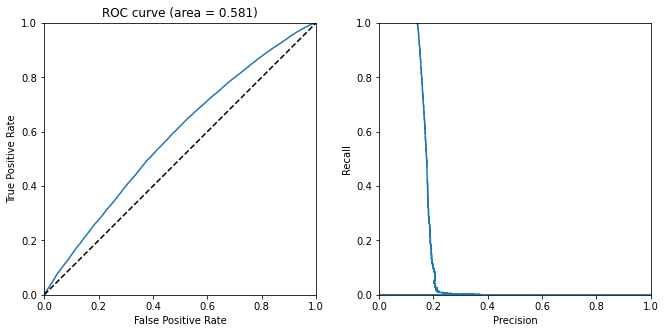

Model metrics with p=0.163:

Test Accuracy: 0.534
Test Precision: 0.170
Test Recall: 0.597
Test ROC Area Under Curve: 0.581
Test confusion:
[[110003 100128]
 [ 13825  20494]]

***

Stratified dummy classifier:

Test Accuracy: 0.742
Test Precision: 0.140
Test Recall: 0.163
Test ROC Area Under Curve: 0.501
Test confusion:
[[175815  34316]
 [ 28738   5581]]

******************************

******************************

******************************

Start model number 27

start data import 2021-07-23 07:18:08.997079
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_12.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2019_1.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2019_2.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2019_3.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2019_4.csv
Read US_DOT/On-Ti

C:\Users\gtate\Anaconda3\envs\tensorflow_environment\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Test Accuracy: 0.900
Test Precision: 0.000
Test Recall: 0.000
Test ROC Area Under Curve: 0.593
Test confusion:
[[311917      0]
 [ 34540      0]]



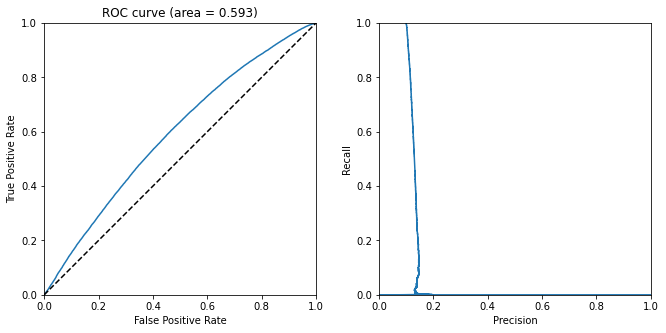

Model metrics with p=0.159:

Test Accuracy: 0.571
Test Precision: 0.127
Test Recall: 0.563
Test ROC Area Under Curve: 0.593
Test confusion:
[[178282 133635]
 [ 15089  19451]]

***

Stratified dummy classifier:

Test Accuracy: 0.773
Test Precision: 0.100
Test Recall: 0.160
Test ROC Area Under Curve: 0.500
Test confusion:
[[262401  49516]
 [ 29028   5512]]

******************************

******************************

******************************

Start model number 28

start data import 2021-07-23 07:34:28.502948
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2019_1.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2019_2.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2019_3.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2019_4.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2019_5.csv
Read US_DOT/On-Tim

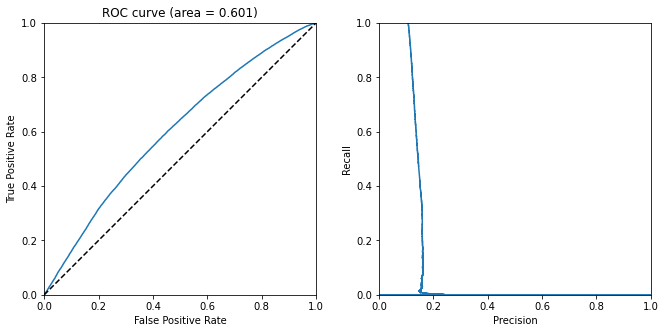

Model metrics with p=0.156:

Test Accuracy: 0.511
Test Precision: 0.133
Test Recall: 0.650
Test ROC Area Under Curve: 0.601
Test confusion:
[[158404 162012]
 [ 13389  24853]]

***

Stratified dummy classifier:

Test Accuracy: 0.771
Test Precision: 0.105
Test Recall: 0.153
Test ROC Area Under Curve: 0.498
Test confusion:
[[270512  49904]
 [ 32402   5840]]

******************************

******************************

******************************

Start model number 29

start data import 2021-07-23 07:50:40.179422
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2019_2.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2019_3.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2019_4.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2019_5.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2019_6.csv
Read US_DOT/On-Tim

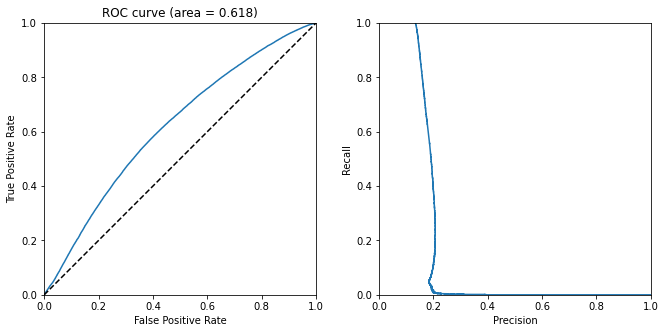

Model metrics with p=0.153:

Test Accuracy: 0.509
Test Precision: 0.171
Test Recall: 0.691
Test ROC Area Under Curve: 0.618
Test confusion:
[[163968 177444]
 [ 16302  36484]]

***

Stratified dummy classifier:

Test Accuracy: 0.753
Test Precision: 0.132
Test Recall: 0.151
Test ROC Area Under Curve: 0.499
Test confusion:
[[289012  52400]
 [ 44840   7946]]

******************************

******************************



In [11]:
train_file_list,val_file_list,test_file_list=moving_train_val_test_windows(test_list_start,test_list_end,
                                                                          months_lag,training_months)

metrics=pd.DataFrame(index=np.arange(len(test_file_list)),
                     columns=['Test_data','Accuracy','Precision','Recall','ROC_AUC','Confusion',
                              'Delays_Prevented','Time_Added','Quantile_Time_Added'])
alt_metrics=pd.DataFrame(index=np.arange(len(test_file_list)),
                     columns=['Test_data','Accuracy','Precision','Recall','ROC_AUC','Confusion','Threshold'])
dummy_metrics=pd.DataFrame(index=np.arange(len(test_file_list)),
                           columns=['Test_data','Accuracy','Precision','Recall','ROC_AUC','Confusion'])


for i in np.arange(len(test_file_list)):
    #set train, val, and test files
    train_files=train_file_list[i]
    val_files=val_file_list[i]
    test_files=test_file_list[i]
    
    test_year_month=test_files[0].split('present)_')[1].split('.csv')[0]
    model_folder=output_folder+test_year_month+'/'
    
    print('******************************\n')
    print('Start model number '+str(i+1))
    print('')
    
    ##############################
    #import and normalize data
    print('start data import '+str(datetime.now()))
    if train_new_model:
        X_train,y_train,airports,X_train_full,y_train_full,_=import_data(train_files,rand_frac_train,
                                    X_vars,X_vars_categorical,y_var,delay_minutes,
                                    X_vars_hours,X_vars_cyclical_dict,
                                    num_airports=num_airports,subsample_imbalanced=imbalanced)
        print('imported train '+str(datetime.now()))

        X_val,y_val,_,_,_,_=import_data(val_files,rand_frac_val,X_vars,X_vars_categorical,y_var,delay_minutes,
                                    X_vars_hours,X_vars_cyclical_dict,airports_list=airports,subsample_imbalanced=imbalanced)
        print('imported validation '+str(datetime.now()))
    else:
        airports=load(model_folder+'airports.joblib')
        X_train_cols=load(model_folder+'X_train_cols.joblib')


    X_test,y_test,_,_,_,df_test=import_data(test_files,rand_frac_test,X_vars,X_vars_categorical,y_var,delay_minutes,
                                X_vars_hours,X_vars_cyclical_dict,airports_list=airports,subsample_imbalanced=imbalanced)
    print('imported test '+str(datetime.now()))

    if train_new_model:
        X_train_normalized,X_val_norm0,X_test_norm0,scaler=normalize(X_train,X_val,X_test,X_vars_normalize,X_vars_log)
        X_val_normalized,X_test_normalized=missing_cat_add(X_train_normalized,X_val_norm0,X_test_norm0)
    else:
        scaler=load(model_folder+'scaler.joblib')
        X_test_norm0=normalize_test_only(X_test,X_vars_normalize,X_vars_log,scaler)
        X_test_normalized=missing_cat_add_test_only(X_test_norm0,X_train_cols)
        
    print('data normalized '+str(datetime.now()))
    

    ##############################
    #train model
    if train_new_model:
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc',verbose=1,patience=10,
                                                          mode='max',restore_best_weights=True)
        model=make_model()

        print('modeling begin '+str(datetime.now()))
        history=model.fit(X_train_normalized,y_train,batch_size=Batch_Size,epochs=Epochs,
                          validation_data=(X_val_normalized,y_val))
        model.save(output_folder.split('/')[0]+'\{}\saved_model'.format(test_year_month))
        #save scaler and other files for later model use
        dump(scaler,model_folder+'scaler.joblib')
        dump(np.mean(y_train_full),model_folder+'Train_delay_proportion.joblib')
        dump(airports,model_folder+'airports.joblib')
        dump(X_train.columns.values.tolist(),model_folder+'X_train_cols.joblib')
        print('model fitted '+str(datetime.now()))
    else:
        model=tf.keras.models.load_model(output_folder.split('/')[0]+'\{}\saved_model'.format(test_year_month))

    
    
    ##############################
    #Evaluate model performance
    print('Model metrics:')
    preds=model.predict_classes(X_test_normalized)
    probs=model.predict_proba(X_test_normalized)
    prob_thresh_add=np.quantile(probs,quantile_time_add)
    delay_prevent=np.sum((df_test[probs>=prob_thresh_add]['ArrDelayMinutes']>=delay_minutes)&
                         (df_test[probs>=prob_thresh_add]['ArrDelayMinutes']<time_add+delay_minutes))/np.sum(y_test)
    print('{:.2f}% of delays prevented'.format(delay_prevent*100))
    print('by adding {} min to arrival times for delay probabilities in top {:.0f}%.'.format(time_add,100*(1-quantile_time_add)))
    acc,prec,rec,auc,conf=evaluate_model(y_test,preds,probs)
    metrics.loc[i,'Test_data']=test_year_month
    metrics.loc[i,'Accuracy']=acc
    metrics.loc[i,'Precision']=prec
    metrics.loc[i,'Recall']=rec
    metrics.loc[i,'ROC_AUC']=auc
    metrics.loc[i,'Confusion']=conf
    metrics.loc[i,'Delays_Prevented']=delay_prevent
    metrics.loc[i,'Time_Added']=time_add
    metrics.loc[i,'Quantile_Time_Added']=quantile_time_add
    
    
    #Evaluate model performance with adjusted proability threshold
    #Default behavior above tests against p=0.50, but by adjusting probability can adjust precision/recall balance
    if train_new_model:
        train_delay_prop=np.mean(y_train_full)
    else:
        train_delay_prop=load(model_folder+'Train_delay_proportion.joblib')
    alt_prob=train_delay_prop #percent of delays in the full training dataset
    print('Model metrics with p={:.3f}:'.format(alt_prob))
    alt_acc,alt_prec,alt_rec,alt_auc,alt_conf=evaluate_model(y_test,probs>alt_prob,probs,plot=False)
    alt_metrics.loc[i,'Test_data']=test_year_month
    alt_metrics.loc[i,'Accuracy']=alt_acc
    alt_metrics.loc[i,'Precision']=alt_prec
    alt_metrics.loc[i,'Recall']=alt_rec
    alt_metrics.loc[i,'ROC_AUC']=alt_auc
    alt_metrics.loc[i,'Confusion']=alt_conf
    alt_metrics.loc[i,'Threshold']=alt_prob
    
    
    #dummy model for comparison: randomly guess with proportion found in full training dataset
    from sklearn.dummy import DummyClassifier
    if train_new_model:
        proportional_dummy=DummyClassifier(strategy='stratified').fit(X_train_full,y_train_full)
    else:
        dummy_y=np.zeros(1000)
        dummy_y[0:int(np.floor(1000*train_delay_prop))]=1
        proportional_dummy=DummyClassifier(strategy='stratified').fit(dummy_y,dummy_y)
    print('***\n')
    print('Stratified dummy classifier:')
    strat_acc,strat_prec,strat_rec,strat_auc,strat_conf=evaluate_model(
        y_test,proportional_dummy.predict(X_test),proportional_dummy.predict_proba(X_test),plot=False)
    dummy_metrics.loc[i,'Test_data']=test_year_month
    dummy_metrics.loc[i,'Accuracy']=strat_acc
    dummy_metrics.loc[i,'Precision']=strat_prec
    dummy_metrics.loc[i,'Recall']=strat_rec
    dummy_metrics.loc[i,'ROC_AUC']=strat_auc
    dummy_metrics.loc[i,'Confusion']=strat_conf
    
    
    print('******************************\n')
    print('******************************\n')

    
    
if save_metrics:
    metrics.to_csv(output_folder+metrics_output)
    alt_metrics.to_csv(output_folder+'alt_'+metrics_output)
    dummy_metrics.to_csv(output_folder+'dummy_'+metrics_output)
    
    
##########
#save variables for reproduction and later testing
if train_new_model:
    dump(X_vars_normalize,output_folder+'X_vars_normalize.joblib')
    dump(X_vars_log,output_folder+'X_vars_log.joblib')
    dump(X_vars_categorical,output_folder+'X_vars_categorical.joblib')
    dump(X_vars_hours,output_folder+'X_vars_hours.joblib')
    dump(X_vars_cyclical_dict,output_folder+'X_vars_cyclical_dict.joblib')
    dump(delay_minutes,output_folder+'delay_minutes.joblib')
    dump(imbalanced,output_folder+'subsample_imbalanced.joblib')



## Cross-Validated Performance
The plot below shows ROC AUC metrics for models tested from January 2019 to May 2021. Models were trained on moving 2-year windows of flight data ending 4 months before the test data. The baseline randomly guesses delays in proportion with delays in the test data. Models were noticeably better than the baseline for all but April 2020 at the height of pandemic disruptions.

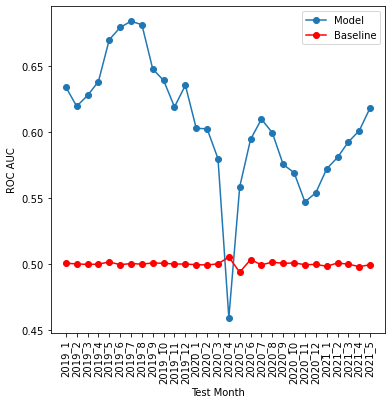

In [12]:
f,ax=plt.subplots(1,figsize=(6,6))
plt.plot(metrics['Test_data'],metrics['ROC_AUC'],'o-',label='Model')
plt.plot(dummy_metrics['Test_data'],dummy_metrics['ROC_AUC'],'ro-',label='Baseline')
plt.xticks(rotation='vertical')
ax.set_xlabel('Test Month')
ax.set_ylabel('ROC AUC')
ax.legend()
plt.show()

## Potential Delay Prevention
Simple adjustments to flight times based on my delay probabilities could save the US overall about 2 billion dollars a year, with 1 billion dollars of those annual savings going to passengers. This is possible by adding just 15 minutes to the arrival time of only the top 10% most likely flight delays. In the cross-validation below over data from 2019-2021, this strategy would reduce the total number of flight delays by about 5-6%. Given that flight delays cost the US 33 billion dollars and US passengers alone 18 billion dollars in 2019, a 5-6% flight delay reduction has a clear chance to save billions of dollars.

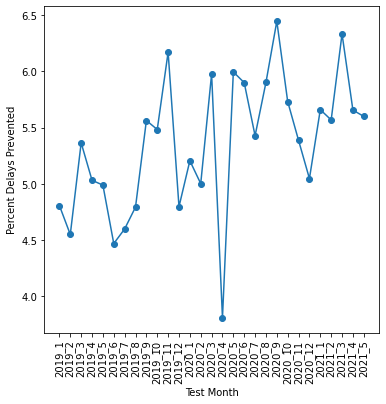

In [13]:
f,ax=plt.subplots(1,figsize=(6,6))
plt.plot(metrics['Test_data'],100*metrics['Delays_Prevented'],'o-')
plt.xticks(rotation='vertical')
ax.set_xlabel('Test Month')
ax.set_ylabel('Percent Delays Prevented')
plt.show()